# Section 1: Knapsack Problem with Genetic Algorithms vs. Dynamic Programming
## Introduction
The problem:
In this assignment, we’ll be using both a Genetic Algorithm to find the solution to a 01-Knapsack Problem. The Knapsack Problem is an optimization problem where given a set of weights and values of $n$ objects, collect them into a bag (or a "knapsack") of maximum value such that their cumulative weight does not exceed capacity. The goal is to get the maximum value from the items in the knapsack. Since this problem is a 01-Knapsack, we can only take one of each object, or none. Read more about the Knapsack Problem [here](https://en.wikipedia.org/wiki/Knapsack_problem).


In notation form, we are trying to maximize $\sum_{i=1}^{n} (values[i]*choices[i])$ subject to $\sum_{i=1}^{n} (weights[i]*choices[i]) \leq capacity$, where $weights[i] \in {0,1}$.

We have provided code stubs in this notebook to get you started, and give hints about the structure of the code.

You need to implement a Genetic Algorithm to find the best Knapsack Solution, and compare the results to the Dynamic Programming Algorithm. Dynamic Programming is another way to solve Knapsack, and it is already coded for you.  

You will need to submit a report along with the finished Jupyter notebook in which you should report the performances in the form of tables as well as plots.


## Approach:  
Let’s start with a few definitions.
- Individual (aka “chromosome”): a solution to the Knapsack problem, called an Allocation. It is specified by a choices array, which is a list of 0's and 1's, each representing whether an object is included in the knapsack. Each Allocation also has a weight associated with it. 
- Population: a collection of possible Allocations (i.e., collection of individuals)
- Parents: two Allocations that are combined to create a new Allocation
- Mating pool: a collection of parents that are used to create our next population (thus creating the next generation of Allocation)
- Fitness: a function that tells us how good each Allocation is (in our case, how much value we gain without exceeding capacity)
- Mutation: a way to introduce variation in our population by randomly inverting elements in the Allocation's choices array. 
- Elitism: a way to carry the best individuals into the next generation    
  
Our GA will proceed in the following steps:
- 1. Create the population
- 2. Rank the population according to fitness in decreasing order
- 3. Select the mating pool
- 4. Breed
- 5. Mutate to create the next generation
- 6. Repeat  
Now, let’s see this in action.

In [1]:
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt
import operator
import math
from sklearn.datasets import load_breast_cancer
import sklearn
from sklearn.model_selection import train_test_split
from datetime import datetime

### Creating the Knapsack Game
Each unique Knapsack game has its own $capacity$ value, $weights$ vector, and $values$ vector. Below is a function used to randomly create a knapsack game of specified size (size = number of objects in knapsack game). We already have used this function to create a game of size 300 that will be used both Genetic Algortihm and Dynamic Programming for comparison later on. 

The functions saveGame() and loadGame() are used to save the game as a file and re-load this file into the notebook, so that everyone is using the same randomly created game. We have provided the game file for you (on Canvas), and we load this file in using the function loadGame(). The game file must be in the same folder as this assignment file. You can upload files to Colab using the file icon in the left pane.

Please note that $n$ = the size parameter used here. In this assignment, we will analyze medium-sized Knapsack games, with 300 objects.

In [2]:
def createGame(size):
    """
    size : the number of objects in the knapsack game
    This function should return a knapsack game in dictionary form 
    """
    upperbound = size // 20 
    choices = range(1, upperbound)
    values = []
    weights = []

    totalWeight = 0
    for i in range(size):
        values.append(random.choice(choices))
        weights.append(random.choice(choices))
        totalWeight += weights[i]
    

    capacity = totalWeight // 2

    game = {'values': values, 'weights': weights, 'capacity': capacity}
    print("Capacity: " + str(capacity))

    return game 

def saveGame(game):
    N = len(game['values'])
    combined = np.array(game['values'] + game['weights'] + [game['capacity']])
    np.savetxt('game.txt', combined)

def loadGame(fname):
    """
    This function loads a knapsack game (weights, values and capacity) from the
    specified file. It returns a dictionary containing these 3 game parameters
    """

    combined = np.loadtxt(fname)
    N = (len(combined) - 1) // 2

    values = combined[:N].tolist()
    weights = combined[N:2*N].tolist()
    capacity = combined[-1]

    return {'values': values, 'weights': weights, 'capacity': capacity}

In [3]:
game = loadGame('game.txt')

## Create necessary classes and functions
We first create a class that will represent and handle an individual in the population, called an Allocation, or a Knapsack Solution. An Allocation is represented by a $choices$ array of 0's and 1's, representing whether we took each object, and a weight variable.

Fitness is calculated as the total value of this Allocation. If $values$ and $choices$ are two arrays each representing every object in this game, this total value is equal to the sum of $value[i]*choices[i]$ for every object in the game. In other words, $\sum_{i=1}^{n} (values[i]*choices[i])$ = fitness for an Allocation with a $choices$ array and a Knapsack game with a $values$ array.





In [4]:
class Allocation:
    def __init__(self, choices):
        """
        choices : an array representing this Allocation's knapsack object choices
        weight : the total weight of this Allocation (assigned later on)
        """
        self.choices = choices
        self.weight = 0
    
    def fitness(self, game):
        """
        game : dictionary containing values, weights, and capacity 
        This fitness function is defined as the total value of this Allocation.
        """
        fitness = np.dot(game['values'], self.choices)
        
        self.weight = np.dot(game['weights'], self.choices)
        
        if self.weight > game['capacity']:
            return -1
        
        else:
            return fitness

## Create our initial population
Allocation generator.  
We now can make our initial population (aka first generation). To do so, we need a way to create a function that produces random Allocations. To create an individual, we randomly select the choice for each object in the knapsack problem. This means that for each object, we decide whether we take the object in the knapsack (assign a value of 1 to choices), or not (assign a value of 0). Even though we are starting out with a completely random initial population, there is still a chance for convergence. 

The first function here produces one random individual, and in the next function, we create the whole initial population by repeatedly calling randomAllocation().

In [5]:
def randomAllocation(game):
    """
    Creates a random Allocation. The elements of the choices array are randomly assigned (0 or 1)
    """
    choices = []
    
    for num in range(len(game['values'])):
        choices.append(random.randint(0, 1))
        
    allocation = Allocation(choices)
        
    return allocation

def initialPopulation(game, popSize):
    """
    Create inital population of a given size.
    Returns a list of random Allocations
    """
    pop = []
    for i in range(popSize):
        temp = randomAllocation(game)
        pop.append(temp)
    
    return pop 

Note: we only have to use these functions to create the initial population. Subsequent generations will be produced through breeding and mutation.

## Create the genetic algorithm - Rank by Fitness
Rank individuals  
Next, the evolutionary fun begins. To simulate our “survival of the fittest”, we can make use of Fitness to rank each individual in the population. Our output will be an ordered list with the Allocation IDs and each associated fitness score.

In [6]:
def rankPopulation(game, population):
    """
    This function sorts the given population in decreasing order of the fitness score.
    Returns a list of ordered pairs of (index, fitness) where index is the index of the
    individual within the population
    """
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = population[i].fitness(game)
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

## Select the mating pool
There are a few options for how to select the parents that will be used to create the next generation. The most common approaches are either fitness proportionate selection (aka “roulette wheel selection”) or tournament selection:
- Fitness proportionate selection (the version implemented below): The fitness of each individual relative to the population is used to assign a probability of selection. Think of this as the fitness-weighted probability of being selected.
- Tournament selection: A set number of individuals are randomly selected from the population and the one with the highest fitness in the group is chosen as the first parent. This is repeated to chose the second parent.  

Another design feature to consider is the use of elitism. With elitism, the best performing individuals from the population will automatically carry over to the next generation, ensuring that the most successful individuals persist.  
For the purpose of clarity, we’ll create the mating pool in two steps. First, we’ll use the output from rankPopulation to determine which Allocations to select in our selection function. Then, we set up the roulette wheel by calculating a relative fitness weight for each individual. Next, we compare a randomly drawn number to these weights to select our mating pool. We’ll also want to hold on to our best Allocations, so we introduce elitism. Ultimately, the selection function returns a list of Allocation IDs, which we can use to create the mating pool in the matingPool function.

In [7]:
def selection(popRanked, eliteSize):
    """
    popRanked: output of rankpopulation()
    eliteSize: number of highest ranked individuals we will retain in the next generation
    This function returns a list of indices of individuals selected to form the mating pool
    """
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

Now that we have the IDs of the Allocations that will make up our mating pool from the selection function, we can create the mating pool. We’re simply extracting the selected individuals from our population.

In [8]:
def matingPool(population, selectionResults):
    """
    Create the mating pool
    """
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

## Breed

With our mating pool created, we can create the next generation in a process called crossover (aka “breeding”). Again, each Allocation can be represented by the choices array. 

You will implement three crossover funtions, and each one will produce two children rather than one. For more efficient breeding, each parent pair will have two children. In each crossover function, it is your job to figure out how to best create two different offsprings for each parent pair. 

In crossover_split, we randomly select an index to split the parents each into two parts, and create two children. The first child should be comprised of the first part of parent1, and the second part of parent2. The second child should be comprised of the first part of parent2, and the second part of parent1.  

There is a crossover wrapper function, which is what gets called later on. Inside of this function, based on the passed crossover type, we call the appopriate function to be used in the genetic algorithm.

In addition to split crossover, you need to implement two additional crossover functions which you must devise. Here, sol1 and sol2 are two different Allocation objects. You can rename the second and third crossover function.


In [9]:
def crossover_split(sol1, sol2):
    """
    sol1, sol2: type Allocation
    Split crossover as described in the write-up
    This function should return two Allocation objects
    """
    split = random.randint(0, len(sol1.choices))
    
    child1 = Allocation(sol1.choices[:split] + sol2.choices[split:])
    child2 = Allocation(sol2.choices[:split] + sol1.choices[split:])
    
    return child1, child2

def random_third(sol1, sol2):
    """
    Your own crossover function. It should return two children created by 
    crossing over sol1 and sol2
    This function should return two Allocation objects
    """
    number = len(sol1.choices) // 3
    selected = random.sample(range(len(sol1.choices)), number)
    child1_choices = list(sol1.choices)
    child2_choices = list(sol2.choices)
    
    for choice in selected:
        child1_choices[choice] = child2_choices[choice]
        child2_choices[choice] = child1_choices[choice]
            
    return Allocation(child1_choices), Allocation(child2_choices)


def ordered_crossover(sol1, sol2):
    """
    Your own crossover function. It should return two children created by 
    crossing over sol1 and sol2
    This function should return two Allocation objects
    """
    start = random.choice(range(len(sol1.choices)))
    stop = random.choice(range(start, len(sol1.choices)))
    
    child1 = Allocation(list(sol1.choices))
    child1.choices[start:stop] = sol2.choices[start:stop]
    
    child2 = Allocation(list(sol2.choices))
    child2.choices[start:stop] = sol1.choices[start:stop]

    return child1, child2


def crossover(sol1, sol2, crossover_type):
    """
    Wrapper function for crossover. Returns the children formed by crossing over 
    sol1 and sol2. 
    crossover_type is a string specifying which crossover function to use.
    """
    if crossover_type == "split":
        return crossover_split(sol1, sol2)
    elif crossover_type == "random third":
        return random_third(sol1, sol2)
    elif crossover_type == "ordered":
        return ordered_crossover(sol1, sol2)

    
    print("Crossover type invalid")
    return None 

Next, we’ll generalize this to create our offspring population. We will use elitism to retain the best Allocations from the current population. Then, we use the crossover wrapper function to fill out the rest of the next generation.

Keep in mind that when calling crossover for two parents, the function will return two children. The children population size will be equal to the size of the original population, or the size of the matingPool. 

Another note to keep in mind is that the top eliteSize members of each population should progress to the next generation without being changed or mutated. When running the genetic Algorithm function, make sure to use an **even** eliteSize, to make calculations easier in the below function. 

In [10]:
def breedPopulation(matingpool, eliteSize, crossover_type):
    """
    matingpool: list of individuals selected to form the mating pool
    eliteSize: number of highest ranked individuals preserved in the next generation
    crossover_type: string specifying which crossover function to use
    This function returns the new population created by breeding
    """
    children = []
    length = len(matingpool) - eliteSize
    length = length // 2
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, length):
        child1, child2 = crossover(pool[i], pool[len(matingpool)-i-1], crossover_type)
        children.append(child1)
        children.append(child2)
    return children

## Mutate
Mutation serves an important function in GA, as it helps to avoid local convergence by introducing novel routes that will allow us to explore other parts of the solution space. In this assignment, we shall assume that we mutate a certain fraction of the population, as specified in the variable `mutationRate`.

Note that there can be several possible ways to mutate an individual for this problem. You need to decide on your own how to mutate an individual. 

In [11]:
def mutate(individual):
    """
    individual: type Allocation
    This function should mutate a single individual and return the mutated individual.
    """
    index = random.randint(0,len(individual.choices)-1)

    if individual.choices[index] == 0:
        individual.choices[index] = 1
    elif individual.choices[index] == 1:
        individual.choices[index] = 0

    return individual

Next, we can extend the mutate function to run through the new population.  
Please create a function to run mutation over entire population and return the new population. The top eliteSize members of the previous population should not be mutated. Each member of the population is mutated with probability mutationRate.

In [12]:
def mutatePopulation(population, mutationRate, eliteSize):
    """
    This function should use the above mutate function to mutate each member of the population. Simply iterate over the 
    population, and mutate each individual with probability mutationRate. 
    The top eliteSize members should remain unchanged. 
    """
    pop_copy = population.copy()
    mutatingPop = pop_copy[eliteSize:]
    new_pop = []
    
    for individual in mutatingPop:
        if random.random() <= mutationRate:
            new_pop.append(mutate(individual))
        else:
            new_pop.append(individual)
            
    mutatedPop = pop_copy[:eliteSize] + new_pop
    
    return mutatedPop

## Repeat
We’re almost there. Let’s pull these pieces together to create a function that produces a new generation. First, we rank the Allocations in the current generation using rankPopulation. We then determine our potential parents by running the selection function, which allows us to create the mating pool using the matingPool function. Finally, we create our new generation using the breedPopulation function (passing in crossover_type) and then applying mutation using the mutatePopulation function.

In [14]:
def nextGeneration(game, currentGen, eliteSize, mutationRate, crossover_type):
    """
    This function takes in the current generation, eliteSize and mutationRate and should return the next generation.
    Please use all the above defined functions to do so, some hints are in the above paragraph.
    """
    popRanked = rankPopulation(game, currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize, crossover_type)
    nextGeneration = mutatePopulation(children, mutationRate, eliteSize)
    return nextGeneration

## Final step: Evolution in motion
We finally have all the pieces in place to create our GA! All we need to do is create the initial population, and then we can loop through as many generations as we desire. 

Of course we also want to see the best Allocation and how much we’ve improved, so we capture the initial fitness, the final fitness, and the best individual. The parameter crossover_type is a string which specifies which crossover function to use. We have the parameter game as a dictionary that is returned by createLargeGame(), and we pass this variable in to other function calls as needed.

Before each generation, you can use the fittest individual from the population to evaluate the fitness performance of the model.

In [15]:
def geneticAlgorithm(game, popSize, eliteSize, mutationRate, generations, crossover_type, iterations):
    """
    This function should run the genetic algorithm for the specified number of generations
    by following the process outlined  in the "Approach" section given earlier in this notebook. 
    It should print the initial and final fitness.
    It should also generate plots showing the fitness with respect to generations.
    """
    highest_fit_list = []
    start = datetime.now()
    
    for it in range(iterations):

        currentGen = initialPopulation(game, popSize)

        initial_fit = max(rankPopulation(game, currentGen)[:][:][0])
        best_individual = initial_fit
        best_individual_gen = 0
        highest_fit_list = []

        for gen in range(generations):

            currentGen = nextGeneration(game, currentGen, eliteSize, mutationRate, crossover_type)
            highest_fit_list.append(max(rankPopulation(game, currentGen)[:][:][0]))

            if max(rankPopulation(game, currentGen)[:][:][0]) > best_individual:
                best_individual = max(rankPopulation(game, currentGen)[:][:][0])
                best_individual_gen = gen + 1

        final_fit = max(rankPopulation(game, currentGen)[:][:][0])

        print('Iteration', it + 1, 'Initial Fitness:', initial_fit)
        print('Iteration', it + 1, 'Final Fitness:', final_fit)
        print('Iteration', it + 1, 'Best Individual has fitness', best_individual,
              'from generation', best_individual_gen)
    
    end = datetime.now()
    print("Time Elapsed for GA: " + str(end - start))
    
    figure, axis = plt.subplots(1,figsize=(10,5))
    figure.tight_layout(pad=5.0)

    axis.plot(range(generations), highest_fit_list)
    axis.set_title('Fitness Across Generations')
    axis.set_xlabel('Generation')
    axis.set_ylabel('Fitness')

    return None

## Knapsack Dynamic Programming

Dynamic Programming is a very useful and popular way of solving many problems in computer science. The technique makes use of repeated function calling, and creates an array or table to store answers to subproblems of our actual problem. 

Our DP array will be defined by the following: $dp[i][j]$ represents the maximum knapsack profit for capacity $j$ calculated from the first $i$ items. This means that each value $dp[i][j]$ depends on previous array elements, and we fill in this array from the bottom-up. Each element in this array represents the solution to a smaller, similar Knapsack subproblem. 

For each item at index $i$ and capacity $j$ there are two options: 

1. Include the item at index $i$ in the knapsack, as long as its weight is not more than $capacity$. If this happens, we get its profit plus the profit we get from the remaining $capacity$ and remaining items: $dp[i][j] = values[i] + dp[i-1][j-weights[i]]$

2. Do not include the item at index $i$. In this case, take whatever profit we get from the sub-array that does not include this item: $dp[i][j] = dp[i-1][j]$

It is alright if you do not understand dynamic programming right away, as it is an advanced computer science topic. All you need to understand is that it is a common way of solving Knapsack problems, and can be used to evaluate the effectiveness of our Genetic Algorithm. The code for dynamic programming has been completely written for you. 

In [16]:
def knapsackDP(game):
    """
    values : values of the objects
    weights: weights of the objects
    capacity: capacity of the game 
    Dynamic Programming for the Knapsack problem. 
    """
    values, weights, capacity = game['values'], game['weights'], game['capacity']
    capacity = int(capacity)
    n = len(values)
    start = datetime.now()

    dp = [[0 for _ in range(capacity + 1)] for _ in range(n)]

    for c in range(capacity + 1):
        if weights[0] <= c:
            dp[0][c] = values[0]

    for i in range(1, n):
        for j in range(1, capacity + 1):
            profit1, profit2 = 0, 0
            if weights[i] <= j:
                profit1 = values[i] + dp[i-1][j - int(weights[i])]
            profit2 = dp[i-1][j]

            dp[i][j] = max(profit1, profit2)
    
    end = datetime.now()
    print("Time elapsed for DP: " + str(end - start))
    print("Final DP sol: " + str(dp[n-1][capacity]))
    return dp[n-1][capacity]

Pass the game in to the DP function for Knapsack. Run the below cell to see results. 

In [17]:
knapsackDP(game)

Time elapsed for DP: 0:00:00.198044
Final DP sol: 1757.0


1757.0

Now run the Genetic Algorithm with the same game. As a reminder, use an **even** eliteSize to make later calculations easier. It may take up to 800 generations for your algorithm to converge to a final value. 

Iteration 1 Initial Fitness: 1166.0
Iteration 1 Final Fitness: 1743.0
Iteration 1 Best Individual has fitness 1743.0 from generation 760
Iteration 2 Initial Fitness: 1174.0
Iteration 2 Final Fitness: 1739.0
Iteration 2 Best Individual has fitness 1739.0 from generation 702
Iteration 3 Initial Fitness: 1206.0
Iteration 3 Final Fitness: 1747.0
Iteration 3 Best Individual has fitness 1747.0 from generation 553
Iteration 4 Initial Fitness: 1174.0
Iteration 4 Final Fitness: 1739.0
Iteration 4 Best Individual has fitness 1739.0 from generation 534
Iteration 5 Initial Fitness: 1182.0
Iteration 5 Final Fitness: 1740.0
Iteration 5 Best Individual has fitness 1740.0 from generation 793
Time Elapsed for GA: 0:39:26.069573


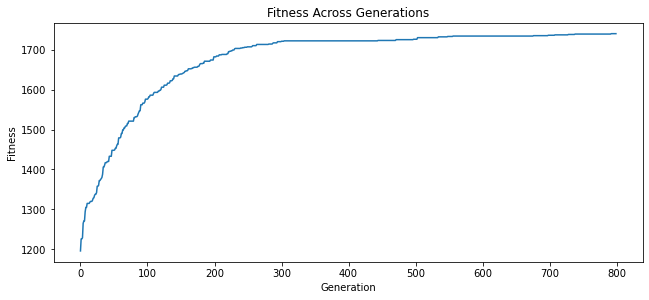

In [18]:
# Split crossover iterations
geneticAlgorithm(game=game, popSize=300, eliteSize=20, mutationRate=0.2, generations=800, crossover_type='split',
                 iterations=5)

Iteration 1 Initial Fitness: 1176.0
Iteration 1 Final Fitness: 1745.0
Iteration 1 Best Individual has fitness 1745.0 from generation 736
Iteration 2 Initial Fitness: 1195.0
Iteration 2 Final Fitness: 1737.0
Iteration 2 Best Individual has fitness 1737.0 from generation 562
Iteration 3 Initial Fitness: 1174.0
Iteration 3 Final Fitness: 1737.0
Iteration 3 Best Individual has fitness 1737.0 from generation 715
Iteration 4 Initial Fitness: 1179.0
Iteration 4 Final Fitness: 1746.0
Iteration 4 Best Individual has fitness 1746.0 from generation 780
Iteration 5 Initial Fitness: 1210.0
Iteration 5 Final Fitness: 1736.0
Iteration 5 Best Individual has fitness 1736.0 from generation 444
Time Elapsed for GA: 0:40:17.911996


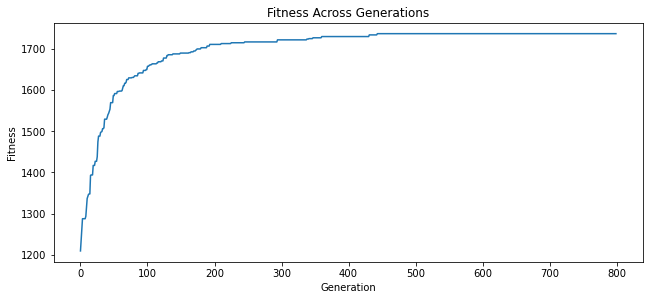

In [19]:
# Random third crossover iterations
geneticAlgorithm(game=game, popSize=300, eliteSize=20, mutationRate=0.2, generations=800, crossover_type='random third',
                 iterations=5)

Iteration 1 Initial Fitness: 1203.0
Iteration 1 Final Fitness: 1748.0
Iteration 1 Best Individual has fitness 1748.0 from generation 724
Iteration 2 Initial Fitness: 1220.0
Iteration 2 Final Fitness: 1746.0
Iteration 2 Best Individual has fitness 1746.0 from generation 792
Iteration 3 Initial Fitness: 1190.0
Iteration 3 Final Fitness: 1746.0
Iteration 3 Best Individual has fitness 1746.0 from generation 744
Iteration 4 Initial Fitness: 1195.0
Iteration 4 Final Fitness: 1745.0
Iteration 4 Best Individual has fitness 1745.0 from generation 798
Iteration 5 Initial Fitness: 1182.0
Iteration 5 Final Fitness: 1744.0
Iteration 5 Best Individual has fitness 1744.0 from generation 795
Time Elapsed for GA: 0:39:28.097545


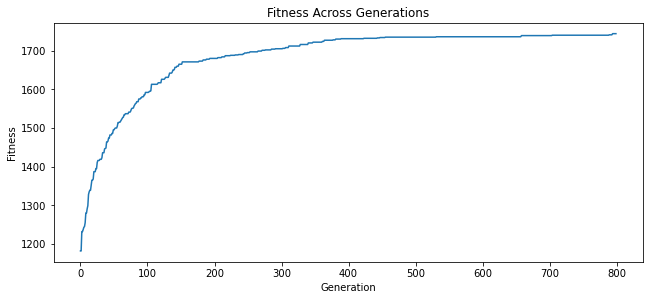

In [20]:
# Ordered crossover iterations
geneticAlgorithm(game=game, popSize=300, eliteSize=20, mutationRate=0.2, generations=800, crossover_type='ordered',
                 iterations=5)

# Section 2: Traveling Salesman Problem
In this section of the assignment, we’ll be using a Genetic Algorithm to find a solution to the traveling salesman problem (TSP). The TSP is described as follows:
“Given a list of cities and the distances between each pair of cities, what is the shortest possible route that visits each city and returns to the origin city?”
![picture](https://drive.google.com/uc?export=view&id=1wRUX0I803AvXbbkWiD1r4_MKuE3mBQdr)
Illustration of a potential solution to the Traveling Salesman Problem.

Given this, there are two important rules to keep in mind:
- Each city needs to be visited exactly one time
- We must return to the starting city, so our total distance needs to be calculated accordingly  
## Approach:  
Let’s start with a few definitions, rephrased in the context of the TSP:
- Gene: a city (represented as (x, y) coordinates)
- Individual (aka “chromosome”): a single route satisfying the conditions above
- Population: a collection of possible routes (i.e., collection of individuals)
- Parents: two routes that are combined to create a new route
- Mating pool: a collection of parents that are used to create our next population (thus creating the next generation of routes)
- Fitness: a function that tells us how good each route is (in our case, how short the distance is)
- Mutation: a way to introduce variation in our population by randomly swapping two cities in a route
- Elitism: a way to carry the best individuals into the next generation    
  
Our GA will proceed in the following steps:
- 1. Create the population
- 2. Determine fitness
- 3. Select the mating pool
- 4. Breed
- 5. Mutate
- 6. Repeat  
Now, let’s see this in action.

## Create necessary classes and functions

Create two classes: City and Fitness  
We first create a City class that will allow us to create and handle our cities. These are simply our (x, y) coordinates. Within the City class, we add a distance calculation (making use of the Pythagorean theorem) in line 6 and a cleaner way to output the cities as coordinates with `__repr __`.

Create class to handle "cities"

In [2]:
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt

In [22]:
class City:
    def __init__(self, y, x):
        self.x = x
        self.y = y
    
    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance
    
    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"

We’ll also create a Fitness class. In our case, we’ll treat the fitness as the inverse of the route distance. We want to minimize route distance, so a larger fitness score is better. Based on Rule #2, we need to start and end at the same place, so this extra calculation is accounted for in line 13  
`(if i + 1 < len(self.route))`  
of the distance calculation.

In [23]:
class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness= 0.0
    
    def routeDistance(self):
        if self.distance ==0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if i + 1 < len(self.route):
                    toCity = self.route[i + 1]
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance
    
    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness

## Create our initial population

Route generator.  
We now can make our initial population (aka first generation). To do so, we need a way to create a function that produces routes that satisfy our conditions (Note: we’ll create our list of cities when we actually run the GA at the end of the tutorial). To create an individual, we randomly select the order in which we visit each city:

In [24]:
def createRoute(cityList):
    route = random.sample(cityList, len(cityList))
    return route

Create first "population" (list of routes)  
This produces one individual, but we want a full population, so let’s do that in our next function. This is as simple as looping through the createRoute function until we have as many routes as we want for our population.

In [25]:
def initialPopulation(popSize, cityList):
    population = []

    for i in range(0, popSize):
        population.append(createRoute(cityList))
    return population

Note: we only have to use these functions to create the initial population. Subsequent generations will be produced through breeding and mutation.

## Create the genetic algorithm - Determine Fitness

Rank individuals  
Next, the evolutionary fun begins. To simulate our “survival of the fittest”, we can make use of Fitness to rank each individual in the population. Our output will be an ordered list with the route IDs and each associated fitness score.

In [26]:
def rankRoutes(population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

## Select the mating pool
There are a few options for how to select the parents that will be used to create the next generation. The most common approaches are either fitness proportionate selection (aka “roulette wheel selection”) or tournament selection:
- Fitness proportionate selection (the version implemented below): The fitness of each individual relative to the population is used to assign a probability of selection. Think of this as the fitness-weighted probability of being selected.
- Tournament selection: A set number of individuals are randomly selected from the population and the one with the highest fitness in the group is chosen as the first parent. This is repeated to chose the second parent.  

Another design feature to consider is the use of elitism. With elitism, the best performing individuals from the population will automatically carry over to the next generation, ensuring that the most successful individuals persist.  
For the purpose of clarity, we’ll create the mating pool in two steps. First, we’ll use the output from rankRoutes to determine which routes to select in our selection function. In lines 3–5, we set up the roulette wheel by calculating a relative fitness weight for each individual. In line 9, we compare a randomly drawn number to these weights to select our mating pool. We’ll also want to hold on to our best routes, so we introduce elitism in line 7. Ultimately, the selection function returns a list of route IDs, which we can use to create the mating pool in the matingPool function.

In [27]:
def selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

Now that we have the IDs of the routes that will make up our mating pool from the selection function, we can create the mating pool. We’re simply extracting the selected individuals from our population.

In [28]:
def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

## Breed
With our mating pool created, we can create the next generation in a process called crossover (aka “breeding”). If our individuals were strings of 0s and 1s and our two rules didn’t apply (e.g., Knapsack problem, or deciding whether or not to include a stock in a portfolio), we could simply pick a crossover point and splice the two strings together to produce an offspring.  
However, the TSP is unique in that we need to include all locations exactly one time. To abide by this rule, we can use a special breeding function called ordered crossover. In ordered crossover, we randomly select a subset of the first parent string (see line 12 in breed function below) and then fill the remainder of the route with the genes from the second parent in the order in which they appear, without duplicating any genes in the selected subset from the first parent (see line 15 in breed function below).
![image.png](attachment:image.png)

In [29]:
def breed(parent1, parent2):
    """
    This function should breed both parents (routes) and return a child route according to the ordered crossover algorithm  
    mentioned above. Please fill in the code to do so.
    """
    start = random.randint(0, len(parent1))
    stop = random.randint(start, len(parent1))
    unique_cities = list(parent2)
    
    for x in parent1[start:stop]:
        if x in unique_cities:
            unique_cities.remove(x)

    child = unique_cities
    child[start:start] = parent1[start:stop]
        
    return child

Next, we’ll generalize this to create our offspring population. In line 5, we use elitism to retain the best routes from the current population. Then, in line 8, we use the breed function to fill out the rest of the next generation.

In [30]:
def breedPopulation(matingpool, eliteSize):
    """
    This function should return the offspring population from the current population using the breed function. It should 
    retain the eliteSize best routes from the current population. Then it should use the breed function to mate
    members of the population, to fill out the rest of the next generation. You may decide how to choose mates for individuals.
    """
    
    children_temp = []
    elites = matingpool[:eliteSize]
    parents = matingpool[eliteSize:]
    
    for ind in range(len(elites)):
        children_temp.append(elites[ind])
    
    for ind in range(len(parents)):
        children_temp.append(breed(parents[ind], parents[len(parents)-ind-1]))
    
    children = children_temp
    
    return children

## Mutate
Mutation serves an important function in GA, as it helps to avoid local convergence by introducing novel routes that will allow us to explore other parts of the solution space. Similar to crossover, the TSP has a special consideration when it comes to mutation. 

Since we need to abide by our rules, we can’t drop cities, and we can use swap mutation. This means that, with specified low probability, two cities will swap places in our route. We’ll do this for one individual in our mutate function. Each individual in the population is mutated, and thus called with mutate(), with probability mutationRate.

In [31]:
def mutate(individual, mutationRate):
    """
    This function should take in an individual (route) and return a mutated individual. Assume mutationRate is a probability
    between 0 and 1. Use the swap mutation described above to mutate the individual according to the mutationRate. Iterate 
    through each of the cities and swap it with another city according to the given probability.
    """
    
    new_individual = list(individual)
    
    for num in range(len(individual)):
        
        choices_list = list(individual)
        choices_list.remove(individual[num])
        rand = random.randint(0, len(choices_list) - 1)
        
        if random.random() < mutationRate:
            new_individual[num], new_individual[rand] = new_individual[rand], new_individual[num]
            
    return new_individual

Next, we can extend the mutate function to run through the new population.  
Please create a function to run mutation over entire population and return the new population. The top eliteSize members of the previous population should not be mutated. Each member of the population is mutated with probability mutationRate.

In [67]:
def mutatePopulation(population, mutationRate, eliteSize):
    """
    This function should use the above mutate function to mutate each member of the population. Simply iterate over the 
    population and mutate each individual using the mutationRate.
    """
    pop_copy = population.copy()
    mutatingPop = pop_copy[eliteSize:]
    new_pop = []
    
    for individual in mutatingPop:
        if random.random() <= mutationRate:
            new_pop.append(mutate(individual, mutationRate))
        else:
            new_pop.append(individual)
            
    mutatedPop = pop_copy[:eliteSize] + new_pop
    
    return mutatedPop

## Repeat
We’re almost there. Let’s pull these pieces together to create a function that produces a new generation. First, we rank the routes in the current generation using rankRoutes. We then determine our potential parents by running the selection function, which allows us to create the mating pool using the matingPool function. Finally, we then create our new generation using the breedPopulation function and then applying mutation using the mutatePopulation function.

In [33]:
def nextGeneration(currentGen, eliteSize, mutationRate):
    """
    This function takes in the current generation, eliteSize and mutationRate and should return the next generation.
    Please use all the above defined functions to do so, some hints are in the above paragraph.
    """
    
    popRanked = rankRoutes(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate, eliteSize)
    return nextGeneration

## Final step: Evolution in motion
We finally have all the pieces in place to create our GA! All we need to do is create the initial population, and then we can loop through as many generations as we desire. Of course we also want to see the best route and how much we’ve improved, so we capture the initial distance in line 3 (remember, distance is the inverse of the fitness), the final distance in line 8, and the best route in line 9.  

In [34]:
def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    print("Initial distance: " + str(1 / rankRoutes(pop)[0][1]))
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
    
    print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    return bestRoute

## Running the genetic algorithm

With everything in place, solving the TSP is as easy as two steps:  
First, we need a list of cities to travel between. For this demonstration, we’ll use the list of 20 biggest cities of United States (a seemingly small number of cities, but brute force would have to test over 300 sextillion(10^21) routes!):

## Create the City list
You need to put all the 20 cities as city objects in the cityList array. We will use the last column Coordinates to calculate the distance between all the cities. And for convenience we will multiply all the coordinates by 100. For example, for New York, it would be  
NewYork= City( int(40.71 * 100), int( -74.00 * 100))  
And then you can put cityList.append(NewYork)

Here is the sample code of calculating the path to travel top 5 cities of U.S.

In [70]:
cityList = []
NewYork= City( int(40.71 * 100), int( -74.00 * 100)) 
LA= City(3405,-11824) 
Chicago=City(4187,-8762)
Houston=City(2976,-9536)
Philly=City(3995,-7516)
cityList.append(NewYork)
cityList.append(LA)
cityList.append(Chicago)
cityList.append(Houston)
cityList.append(Philly)

Then, running the genetic algorithm is one simple line of code. This is where art meets science; you should see which assumptions work best for you. In this example, we have 100 individuals in each generation, keep 5 elite individuals, use a 1% mutation rate for a given gene, and run through 500 generations:

In [71]:
geneticAlgorithm(population=cityList, popSize=100, eliteSize=5, mutationRate=0.01, generations=500)

Initial distance: 9256.22933537916
Final distance: 9256.22933537916


[(-8762,4187), (-7400,4071), (-7516,3995), (-9536,2976), (-11824,3405)]

Therefore, the ideal path to travel is New York - Chicago - LA - Houston - Philly -New York
Or Chicago - LA - Houston - Philly - New York - Chicago etc.   
(They are the same, just the starting point is random and could be different)

## Visualize the result path

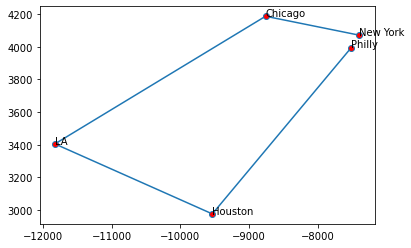

In [37]:
#Plotting
fig, ax1 = plt.subplots(ncols=1)
y=[4071,4187,3405,2976,3995]
x=[-7400,-8762,-11824,-9536,-7516]
n=['New York','Chicago',"LA","Houston","Philly"]
ax1.plot(x, y, marker="o", markerfacecolor="r")
for i, txt in enumerate(n):
    ax1.annotate(txt, (x[i], y[i]))

# Your Turn
Now write the code to calculate the ideal path for traveling the top 20 cities of U.S.

In [72]:
cityList = []

New_York = City(4071, -7400)
Los_Angeles = City(3405,-11824) 
Chicago = City(4187,-8762)
Houston = City(2976,-9537)
Philadelphia = City(3995,-7517)
Phoenix = City(3345, -11207)
San_Antonio = City(2942, -9849)
San_Diego = City(3271, -11716)
Dallas = City(3278, -9680)
San_Jose = City(3734, -12189)
Austin = City(3027, -9774)
Indianapolis = City(3977, -8616)
Jacksonville = City(3033, -8166)
San_Francisco = City(3777, -12242)
Columbus = City(3996, -8299)
Charlotte = City(3523, -8084)
Fort_Worth = City(3276, -9733)
Detroit = City(4233, -8305)
El_Paso = City(3176, -10649)
Memphis = City(3515, -9005)

cityList.append(New_York)
cityList.append(Los_Angeles)
cityList.append(Chicago)
cityList.append(Houston)
cityList.append(Philadelphia)
cityList.append(Phoenix)
cityList.append(San_Antonio)
cityList.append(San_Diego)
cityList.append(Dallas)
cityList.append(San_Jose)
cityList.append(Austin)
cityList.append(Indianapolis)
cityList.append(Jacksonville)
cityList.append(San_Francisco)
cityList.append(Columbus)
cityList.append(Charlotte)
cityList.append(Fort_Worth)
cityList.append(Detroit)
cityList.append(El_Paso)
cityList.append(Memphis)

In [73]:
geneticAlgorithm(population=cityList, popSize=100, eliteSize=10, mutationRate=0.01, generations=500)

Initial distance: 27394.699735499864
Final distance: 11771.828687193754


[(-8299,3996),
 (-8305,4233),
 (-7400,4071),
 (-7517,3995),
 (-8084,3523),
 (-8166,3033),
 (-9680,3278),
 (-9733,3276),
 (-10649,3176),
 (-11207,3345),
 (-12242,3777),
 (-12189,3734),
 (-11824,3405),
 (-11716,3271),
 (-9849,2942),
 (-9774,3027),
 (-9537,2976),
 (-9005,3515),
 (-8762,4187),
 (-8616,3977)]

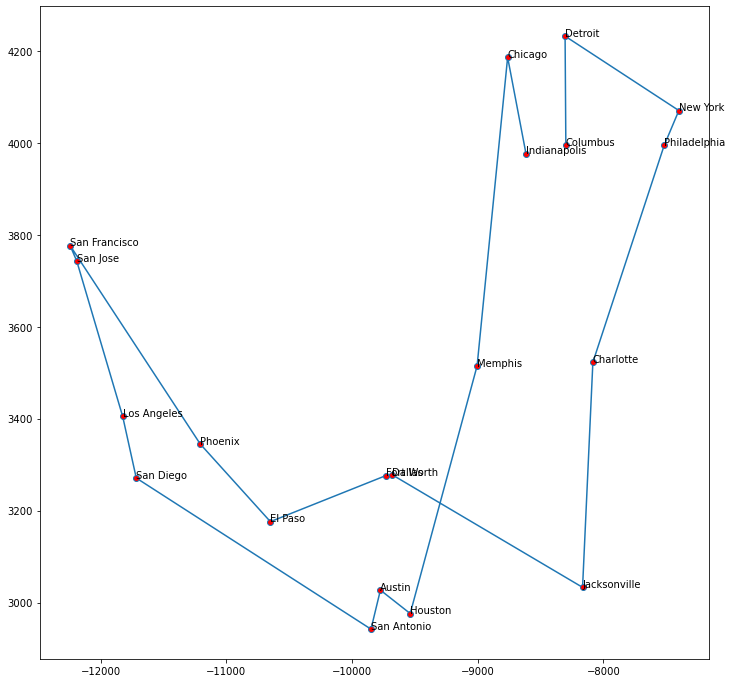

In [4]:
#Plotting
fig, ax1 = plt.subplots(ncols=1, figsize=(12,12))
y=[3996,4233,4071,3995,3523,3033,3278,3276,3176,
   3345,3777,3743,3405,3271,2942,3027,2976,3515,
   4187,3977]
x=[-8299,-8305,-7400,-7517,-8084,-8166,-9680,-9733,
   -10649,-11207,-12242,-12189,-11824,-11716,-9849,
   -9774,-9537,-9005,-8762,-8616]
n=['Columbus','Detroit','New York','Philadelphia',
   'Charlotte','Jacksonville','Dallas','Fort Worth',
   'El Paso','Phoenix','San Francisco','San Jose',
   'Los Angeles','San Diego','San Antonio','Austin',
   'Houston','Memphis','Chicago','Indianapolis']
ax1.plot(x, y, marker="o", markerfacecolor="r")
for i, txt in enumerate(n):
    ax1.annotate(txt, (x[i], y[i]))

# Question: What is the optimal path of cities your GA gave you?

Answer: Columbus - Detroit - New York - Philadelphia - Charlotte - Jacksonville - Dallas - Fort Worth - El Paso - Phoenix - San Francisco - San Jose - Los Angeles - San Diego - San Antonio - Austin - Houston - Memphis - Chicago - Indianapolis

## Plot the progress

It’s great to know our starting and ending distance and the proposed route, but we would be remiss not to see how our distance improved over time. With a simple tweak to our geneticAlgorithm function, we can store the shortest distance from each generation in a progress list and then plot the results.

In [41]:
def geneticAlgorithmPlot(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    progress = []
    fitness = []
    progress.append(1 / rankRoutes(pop)[0][1])
    fitness.append(rankRoutes(pop)[0][1])
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        progress.append(1 / rankRoutes(pop)[0][1])
        fitness.append(rankRoutes(pop)[0][1])
    
    figure, axis = plt.subplots(2, figsize=(10,10))
    figure.tight_layout(pad=5.0)
    
    axis[0].plot(progress)
    axis[0].set_title('Distance over generations')
    axis[0].set_ylabel('Distance')
    axis[0].set_xlabel('Generation')
    
    axis[1].plot(fitness)
    axis[1].set_title('Fitness over generations')
    axis[1].set_ylabel('Fitness')
    axis[1].set_xlabel('Generation')

Run the GA in the same way as before, but now using the newly created geneticAlgorithmPlot function:

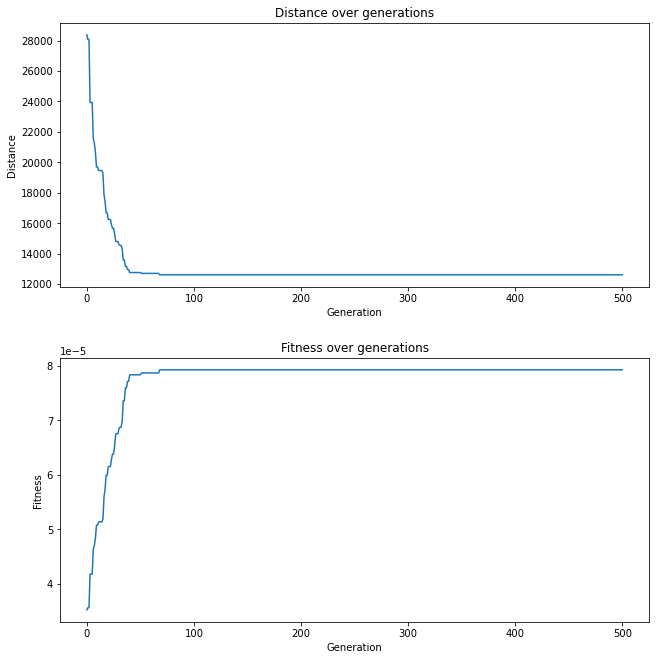

In [42]:
geneticAlgorithmPlot(population=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=500)

## Report and Submission Guidelines

The purpose of this assignment is to develop a better understanding of how Genetic Algorithms can be applied in different problem settings.  

You need to implement a total of **3** crossover functions and **1** fitness function, as well as **1** mutation function. As for mutation, you can choose any mutation rate or even a different mutation strategy which gives you the best testing performance.

The best way to analyze an algorithm is to run many iterations, and record the results. For this assignment, each time you call the geneticAlgorithm function, you use a certain crossover function. There are 3 crossover functions, which means there are 3 possible combinations. We want to compare the performance of these crossover functions.

For each combination type of crossover function, you should run the geneticAlgorithm function atleast 5 times. Then, take the average final fitness of these 5 iterations for this specific combination, and report these in a table. 

The final report should contain an fitness table, that has the average final fitness values for each combination of the genetic algorithm. Please also mention the value of the Dynamic Programming solution, and compare it to the Genetic Algorithm solution. Additionally, for each type of crossover, please produce one plot (pick one of the 5 iterations) that plots fitness versus number of generations for the data. 

For the Traveling Salesman portion, produce a plot that graphs fitness versus number of generations, report the single best individual route (cityList), and plot the final route in a picture. Ie you should plot each city as a point and draw lines between consecutive cities in the final route.

To summarize, you need to write the following in your report:
- Fitnesses table as specified above
- Value of the Dynamic Programming solution
- Fitness plots with respect to generation for all 3 combinations
- Description of your mutation function as well as crossover functions
- Brief (1 paragraph) description of why your mutation/crossover functions work well, or why they don't work well. Basically a possible justification of the performance.
- Traveling Salesman fitness plot
- Traveling Salesman final route (cityList)
- Traveling Salesman final route plot.

## Conclusion
I hope this was a fun, hands-on assignment to continue with GA practice, and analyze results for two common problems. If you want to take this to the next step try to implement a GA on another problem set; see how you would change the breed and mutate functions to handle other types of chromosomes. We’re just scratching the surface here!